## Analysis of the cityscape instance segmentation dataset

In [1]:
import cv2
import os 
import numpy as np
import json
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm

### Utility functions for analysing cityscape dataset

In [2]:
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
    ]

name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }

def _load_image_set_idx(_image_set):
    image_set_file = os.path.join(
        r"D:\leftImg8bit_trainvaltest\leftImg8bit", 'ImageSets', _image_set+'.txt')
    assert os.path.exists(image_set_file), \
        'File does not exist: {}'.format(image_set_file)
    with open(image_set_file) as f:
        image_idx = [x.strip() for x in f.readlines()]
    return image_idx

def get_8_point_mask_parameterization(polygon, height, width):
    outline = np.array(polygon)
    rrr, ccc = outline[:,1], outline[:,0]
    rr = []
    cc = []
    for r in rrr:
        if r < 0:
            r = 0
        if r > height:
            r = height
        rr.append(r)
    for c in ccc:
        if c < 0:
            c = 0
        if c > width:
            c = width
        cc.append(c)
    rr = np.array(rr)
    cc = np.array(cc)
    sum_values = cc + rr
    diff_values = cc - rr
    xmin = max(min(cc), 0)
    xmax = min(max(cc), width)
    ymin = max(min(rr), 0)
    ymax = min(max(rr), height)
    width       = xmax - xmin
    height      = ymax - ymin
    center_x  = xmin + 0.5*width 
    center_y  = ymin + 0.5*height
    center = (center_x, center_y)
    min_sum_indices = np.where(sum_values == np.amin(sum_values))[0][0]
    pt_p_min = (cc[min_sum_indices], rr[min_sum_indices])
    max_sum_indices = np.where(sum_values == np.amax(sum_values))[0][0]
    pt_p_max = (cc[max_sum_indices], rr[max_sum_indices])
    min_diff_indices = np.where(diff_values == np.amin(diff_values))[0][0]
    pt_n_min = (cc[min_diff_indices], rr[min_diff_indices])
    max_diff_indices = np.where(diff_values == np.amax(diff_values))[0][0]
    pt_n_max = (cc[max_diff_indices], rr[max_diff_indices])
    pts = [pt_p_min, pt_n_min, pt_p_max, pt_n_max]
    mask_vector = [xmin, ymin, xmax, ymax, pts[0], pts[1], pts[2], pts[3], center_x, center_y, width, height]
    return mask_vector

def assureSingleInstance(name):
    # if the name is known, it is not a group
    if name in name2label:
        return name2label[name], name
    # test if the name actually denotes a group
    if not name.endswith("group"):
        return None, None
    # remove group
    name = name[:-len("group")]
    # test if the new name exists
    if not name in name2label:
        return None, None
    return name2label[name], name

def get_bgr_mean(data_split):
    path_var = data_split
    _image_idx = _load_image_set_idx(data_split)
    img_counter = 0
    for count, index in enumerate(_image_idx):
        filename = os.path.join(r"D:\leftImg8bit_trainvaltest\leftImg8bit", path_var, 'image_2', index+'.png')
        if count == 0:
            sum_image = cv2.imread(filename).astype(float)
            print("Shape of first image:", sum_image.shape)
        else:
            sum_image += cv2.imread(filename).astype(float)
        img_counter += 1
    print("Number of images in dataset:", data_split, " is:", img_counter, "(0:", count, ")")
    mean_image = sum_image/img_counter
    print(np.shape(mean_image))
    bgr_mean = [np.mean(mean_image[:,:,0]), np.mean(mean_image[:,:,1]), np.mean(mean_image[:,:,2])]
    return bgr_mean, sum_image, mean_image
            
def get_statistics(data_split):
    permitted_classes = ['person', 'rider', 'car', 'truck', 'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle']
    path_var = data_split
#     if data_split == 'train':
#         path_var = 'training'
    _image_idx = _load_image_set_idx(data_split)
    total_artifacts = []
    counter = {}
    for index in _image_idx:
        artifacts = []
        filename = os.path.join(r"D:\leftImg8bit_trainvaltest\leftImg8bit",path_var,"instance", index[:-11]+'gtFine_polygons.json')
        with open(filename) as f:
            data_dict = json.load(f)
            imgHeight = data_dict['imgHeight']
            imgWidth = data_dict['imgWidth']
            instances = data_dict['objects']
            for instance in instances:
                class_name = instance['label']
                params, modified_name = assureSingleInstance(class_name)
                if params != None and params.hasInstances and modified_name in permitted_classes:
                    if class_name in counter:
                        counter[class_name] += 1
                    else:
                        counter[class_name] = 1
                    polygon = np.array(instance['polygon'])
                    vector = get_8_point_mask_parameterization(polygon, imgHeight, imgWidth) 
                    xmin, ymin, xmax, ymax, of1, of2, of3, of4, of5, of6, of7, of8 = vector
                    assert xmin >= 0.0 and xmin <= xmax, \
                        'Invalid bounding box x-coord xmin {} or xmax {} at {}.txt' \
                            .format(xmin, xmax, index)
                    assert ymin >= 0.0 and ymin <= ymax, \
                        'Invalid bounding box y-coord ymin {} or ymax {} at {}.txt' \
                            .format(ymin, ymax, index)
                    w = xmax-xmin
                    h = ymax-ymin
                    artifacts.append([w, h, class_name])
        total_artifacts.append(artifacts)
    print("Number of artifacts found for datasplit ", data_split, ": ", len(total_artifacts))
    return total_artifacts, counter, imgWidth, imgHeight

### Load statistics

In [3]:
# Training statistics:
train_total_artifacts, counter_train, imgW, imH = get_statistics('train')
# Val statistics:
val_total_artifacts, counter_val, imgW, imH  = get_statistics('val')

Number of artifacts found for datasplit  train :  2975
Number of artifacts found for datasplit  val :  500


### Plot frequency of occurance by class

56264 10738


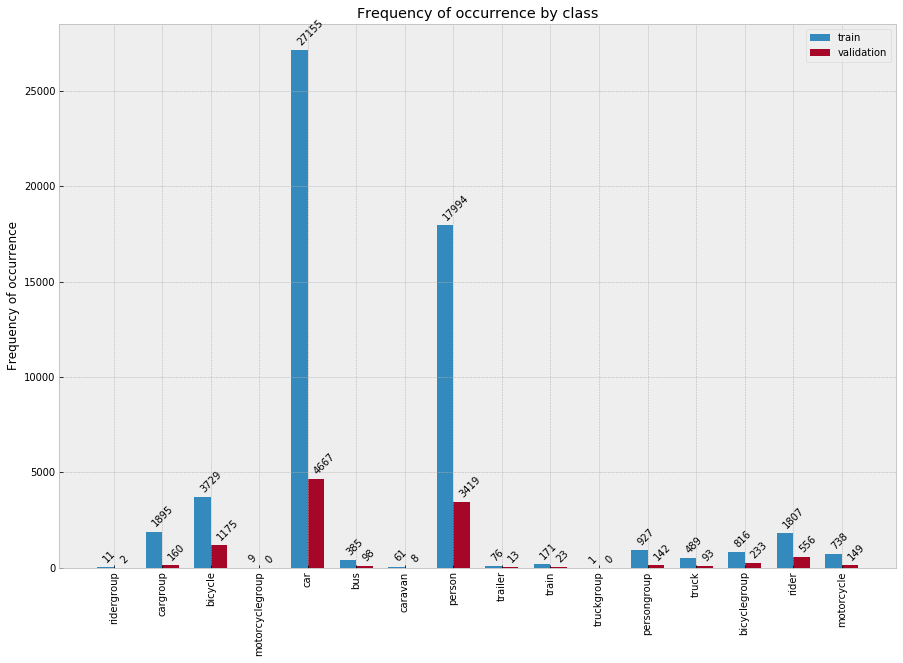

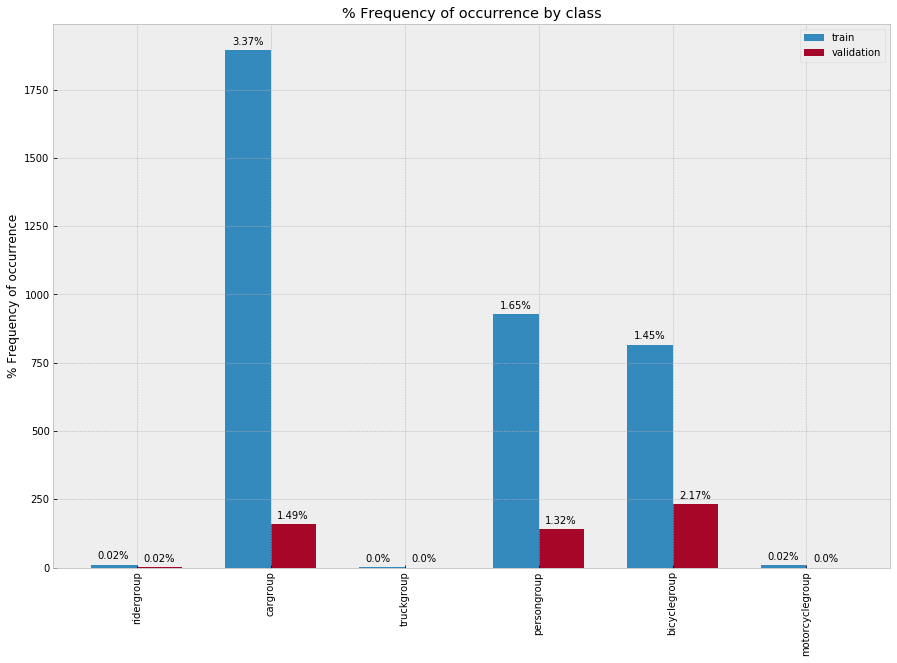

In [4]:
plt.style.use('bmh')
all_keys = set(list(counter_train.keys())+list(counter_val.keys()))

total_count_train = np.sum(list(counter_train.values()))
total_count_val = np.sum(list(counter_val.values()))
print(total_count_train, total_count_val)

final_dict_train = {}
final_dict_val = {}
for key in all_keys:
    if key in counter_train:
        final_dict_train[key] = counter_train[key]
    else:
        final_dict_train[key] = 0
    
    if key in counter_val:
        final_dict_val[key] = counter_val[key]
    else:
        final_dict_val[key] = 0

x = np.array(range(len(all_keys)))
width = 0.34  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, final_dict_train.values(), width, label='train')
rects2 = ax.bar(x + width/2, final_dict_val.values(), width, label='validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency of occurrence')
ax.set_title('Frequency of occurrence by class')
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90)
for i, v in enumerate(final_dict_train.values()):
#     ax.text(i-width+0.09, v + 250, str(round(v/total_count_train*100,2))+"%", color='black', rotation=45, fontsize=10)
    ax.text(i-width+0.09, v + 250, str(v), color='black', rotation=45, fontsize=10)
for i, v in enumerate(final_dict_val.values()):
#     ax.text(i+0.09, v + 250, str(round(v/total_count_val*100,2))+"%", color='black', rotation=45, fontsize=10)
    ax.text(i+0.09, v + 250, str(v), color='black', rotation=45, fontsize=10)
ax.legend()

############### GROUP in CLASSES ############### 

final_dict_train = {}
final_dict_val = {}
all_keys = set([key for key in counter_train.keys() if 'group' in key]+[key for key in counter_val.keys() if 'group' in key])

for key in all_keys:
    if key in counter_train:
        final_dict_train[key] = counter_train[key]
    else:
        final_dict_train[key] = 0

    if key in counter_val:
        final_dict_val[key] = counter_val[key]
    else:
        final_dict_val[key] = 0

x = np.array(range(len(all_keys)))
width = 0.34  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, final_dict_train.values(), width, label='train')
rects2 = ax.bar(x + width/2, final_dict_val.values(), width, label='validation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Frequency of occurrence')
ax.set_title('% Frequency of occurrence by class')
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90)
for i, v in enumerate(final_dict_train.values()):
    ax.text(i-width+0.05, v + 20, str(round(v/total_count_train*100,2))+"%", color='black', rotation=0, fontsize=10)
for i, v in enumerate(final_dict_val.values()):
    ax.text(i+0.05, v + 20, str(round(v/total_count_val*100,2))+"%", color='black', rotation=0, fontsize=10)
ax.legend()


### Plot of frequency of occurance by class as a scatter plot

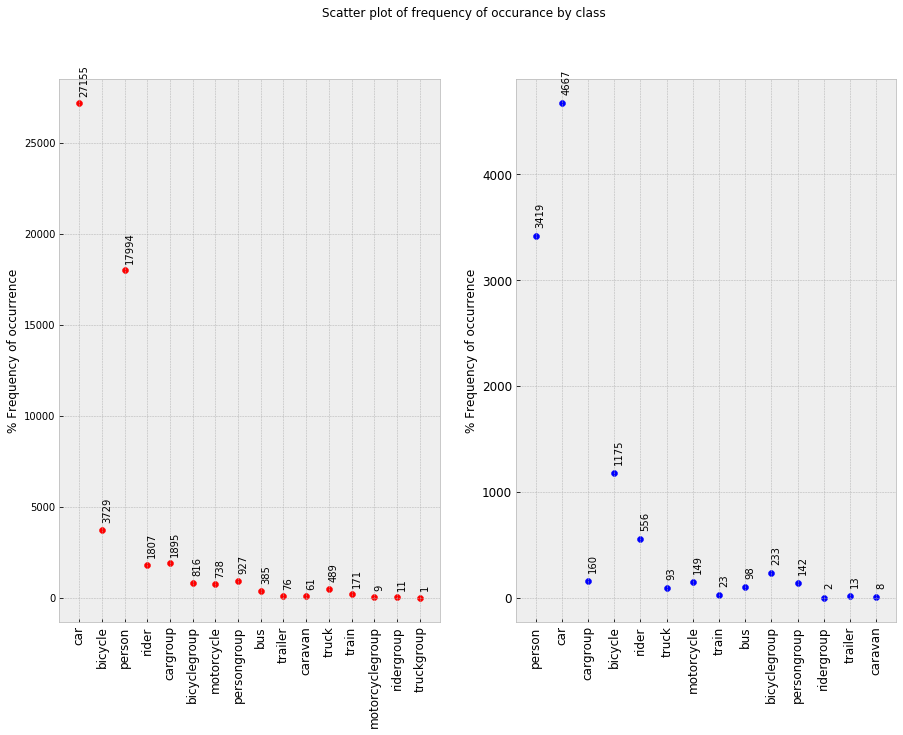

In [5]:
fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.suptitle('Scatter plot of frequency of occurance by class')
axs[0].set_ylabel('% Frequency of occurrence')
plt.yticks(fontsize=12)
x_train = list(range(len(counter_train.keys())))
axs[0].set_xticks(x_train) 
axs[0].set_xticklabels(counter_train.keys(), fontsize=12, rotation=90)  
axs[0].scatter(x_train, counter_train.values(), c='r')
for i, v in enumerate(counter_train.values()):
    axs[0].text(i, v+500, str(v), color='black', rotation=90, fontsize=10)

axs[1].set_ylabel('% Frequency of occurrence')
x_val = list(range(len(counter_val.keys())))
axs[1].set_xticks(x_val) 
axs[1].set_xticklabels(counter_val.keys(), fontsize=12, rotation=90)
axs[1].scatter(x_val, counter_val.values(), c='b')
for i, v in enumerate(counter_val.values()):
    axs[1].text(i, v + 100, str(v), color='black', rotation=90, fontsize=10)
plt.show()

### Anchor shapes and width and height distributions of different classes

In [6]:
vgg_anchors = np.array( [[  36.,  37.], [ 366., 174.], [ 115.,  59.],
           [ 162.,  87.], [  38.,  90.], [ 258., 173.],
           [ 224., 108.], [  78., 170.], [  72.,  43.]])

resnet_anchors = np.array( [[  94.,  49.], [ 225., 161.], [ 170.,  91.],
           [ 390., 181.], [  41.,  32.], [ 128.,  64.],
           [ 298., 164.], [ 232.,  99.], [  65.,  42.]])

squeezeDet_anchors = np.array( [[  36.,  37.], [ 366., 174.], [ 115.,  59.],
           [ 162.,  87.], [  38.,  90.], [ 258., 173.],
           [ 224., 108.], [  78., 170.], [  72.,  43.]])

squeezeDet_plus_anchors = np.array( [[  36.,  37.], [ 366., 174.], [ 115.,  59.],
           [ 162.,  87.], [  38.,  90.], [ 258., 173.],
           [ 224., 108.], [  78., 170.], [  72.,  43.]])

all_keys = set(list(counter_train.keys())+list(counter_val.keys()))

total_count_train = np.sum(list(counter_train.values()))
total_count_val = np.sum(list(counter_val.values()))
print(total_count_train, total_count_val)

final_dict_train = {}
final_dict_val = {}
for key in all_keys:
    if key in counter_train:
        final_dict_train[key] = counter_train[key]
    else:
        final_dict_train[key] = 0
    
    if key in counter_val:
        final_dict_val[key] = counter_val[key]
    else:
        final_dict_val[key] = 0

x = np.array(range(len(all_keys)))
reshaped_train_total_artifacts = []
reshaped_val_total_artifacts = []
for artifacts in train_total_artifacts:
    for artifact in artifacts:
        reshaped_train_total_artifacts.append(artifact)
        
for artifacts in val_total_artifacts:
    for artifact in artifacts:
        reshaped_val_total_artifacts.append(artifact)

def plot_class_profiles(width_scale, height_scale, title_pos):
    #Scale the ground-truth
    num_cols = 2
    num_rows = math.ceil(len(all_keys) / num_cols)
    fig, axs = plt.subplots(num_rows,num_cols,figsize=(15,60))
    fig.suptitle('Object Height vs Object Width for different classes: ', y=title_pos, fontsize = 18)
    heights = []
    widths = []
    for i, key in enumerate(all_keys):
        widths_train = []
        widths_val = []
        heights_train = []
        heights_val = []
        if key in counter_train.keys():
            widths_train = [reshaped_train_total_artifacts[j][0] for j in range(len(reshaped_train_total_artifacts)) if reshaped_train_total_artifacts[j][2] == key]
        if key in counter_val.keys():
            widths_val = [reshaped_val_total_artifacts[j][0] for j in range(len(reshaped_val_total_artifacts)) if reshaped_val_total_artifacts[j][2] == key]
        if len(widths_train) > 0:
            widths = widths_train
        if len(widths_val) > 0:
            widths += widths_val
        if key in counter_train.keys():
            heights_train = [reshaped_train_total_artifacts[j][1] for j in range(len(reshaped_train_total_artifacts)) if reshaped_train_total_artifacts[j][2] == key]
        if key in counter_val.keys():
            heights_val = [reshaped_val_total_artifacts[j][1] for j in range(len(reshaped_val_total_artifacts)) if reshaped_val_total_artifacts[j][2] == key]
        if len(heights_train) > 0:
            heights = heights_train
        if len(heights_val) > 0:
            heights += heights_val
    #     fig = plt.figure(figsize=(15,10))
        #Parameters to set
        widths = np.multiply(widths,width_scale) 
        heights = np.multiply(heights,height_scale)
        print('object:', key, np.shape(widths), np.shape(heights))
        mu_w = np.mean(widths)
        mu_h = np.mean(heights)
        if len(widths) > 1 and len(widths) > 1:
            cov_mat = np.cov(widths,heights)
#             print(cov_mat, key, np.shape(widths), np.shape(heights))
            max_width_lim = int(max(max(widths), max(vgg_anchors[:,0]), max(resnet_anchors[:,0])))
            max_height_lim = int(max(max(heights), max(vgg_anchors[:,1]), max(resnet_anchors[:,1])))
            X = list(range(min(min(widths),0)-10,max_width_lim+10))
            Y = list(range(min(min(heights),0)-10,max_height_lim+10))
            X, Y = np.meshgrid(X, Y)
            pos = np.empty(X.shape + (2,))
            pos[:, :, 0] = X
            pos[:, :, 1] = Y
            #Create grid and multivariate normal
            rv = multivariate_normal([mu_w, mu_h], cov_mat)
            Z = rv.pdf(pos)
            cset = axs[i//num_cols][i%num_cols].contourf(X, Y, Z, cmap=cm.bone_r, alpha=0.9)
            axs[i//num_cols][i%num_cols].scatter(widths, heights, alpha=0.4, c='r', s=10, label='Ground-truth boxes')
            axs[i//num_cols][i%num_cols].set_ylabel(key+' Heights')
            axs[i//num_cols][i%num_cols].set_xlabel(key+' Widths')
            colors = cm.cool(np.linspace(0, 1, 10))
            axs[i//num_cols][i%num_cols].scatter(vgg_anchors[:,0], vgg_anchors[:,1], alpha=0.4, s=70, marker='X', label='VGG/SqueezeDet/SqueezeDet+ ANCHORS', color=colors[1])
            axs[i//num_cols][i%num_cols].scatter(resnet_anchors[:,0], resnet_anchors[:,1], alpha=0.4, s=70, marker='X', label='ResNet ANCHORS', color=colors[7])
            max_vgg_anchor = vgg_anchors[np.argmax(vgg_anchors[:,0]+ vgg_anchors[:,1])]
            max_resnet_anchor = resnet_anchors[np.argmax(resnet_anchors[:,0]+ resnet_anchors[:,1])]
            axs[i//num_cols][i%num_cols].plot([max_vgg_anchor[0], max_vgg_anchor[0]], [0, max_vgg_anchor[1]], alpha=0.4, color=colors[1])
            axs[i//num_cols][i%num_cols].plot([0, max_vgg_anchor[0]], [max_vgg_anchor[1], max_vgg_anchor[1]], alpha=0.4, color=colors[1])
            axs[i//num_cols][i%num_cols].plot([max_resnet_anchor[0], max_resnet_anchor[0]], [0, max_resnet_anchor[1]], alpha=0.4, color=colors[7])
            axs[i//num_cols][i%num_cols].plot([0, max_resnet_anchor[0]], [max_resnet_anchor[1], max_resnet_anchor[1]], alpha=0.4, color=colors[7])
            axs[i//num_cols][i%num_cols].legend()
            axs[i//num_cols][i%num_cols].grid()
        else:
            print("Multivariate analysis not possible with an array having a single value", key)
    #     break

56264 10738


### Rescaling the cityscape dataset to match the size of Kitti dataset used by SqueezeDet+

object: ridergroup (13,) (13,)
object: cargroup (2055,) (2055,)
object: bicycle (4904,) (4904,)
object: motorcyclegroup (9,) (9,)
object: car (31822,) (31822,)
object: bus (483,) (483,)
object: caravan (69,) (69,)
object: person (21413,) (21413,)
object: trailer (89,) (89,)
object: train (194,) (194,)
object: truckgroup (1,) (1,)
Multivariate analysis not possible with an array having a single value truckgroup
object: persongroup (1069,) (1069,)
object: truck (582,) (582,)
object: bicyclegroup (1049,) (1049,)
object: rider (2363,) (2363,)
object: motorcycle (887,) (887,)


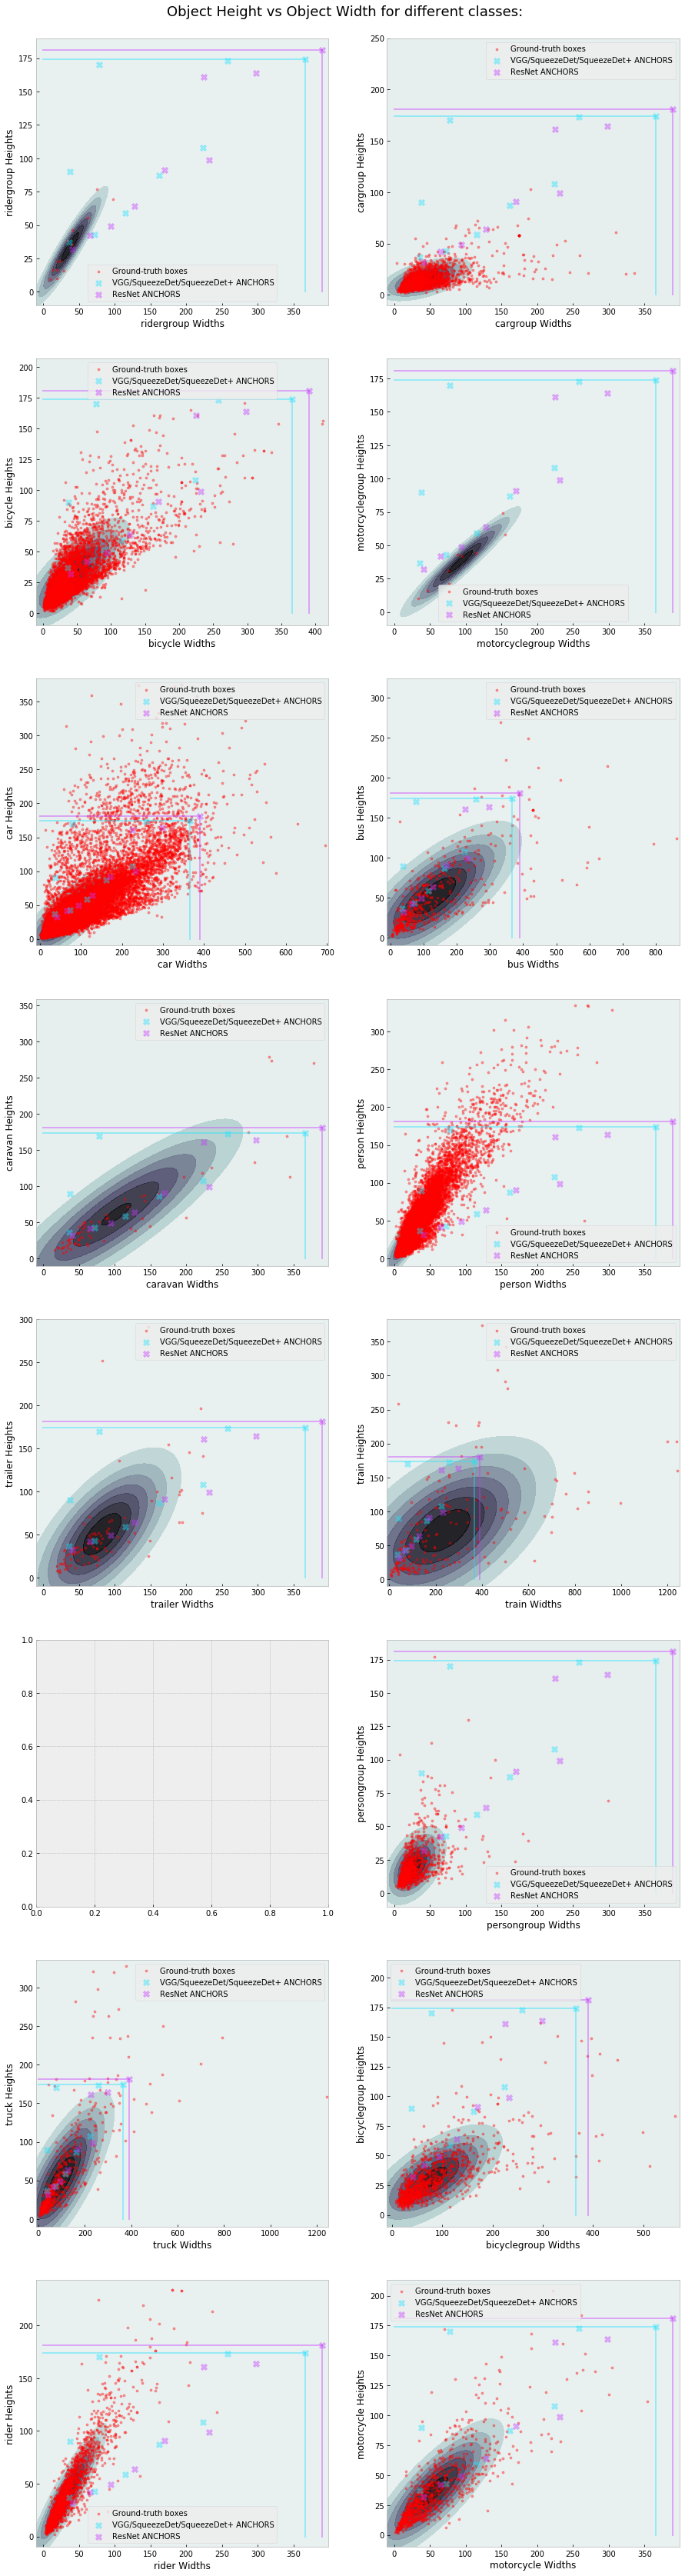

In [7]:
width_scale = 1242/imgW
height_scale = 375/imH
plot_class_profiles(width_scale, height_scale, 0.89)

### Rescaling the cityscape dataset to half of its shape maintaining the aspect ratio

object: ridergroup (13,) (13,)
object: cargroup (2055,) (2055,)
object: bicycle (4904,) (4904,)
object: motorcyclegroup (9,) (9,)
object: car (31822,) (31822,)
object: bus (483,) (483,)
object: caravan (69,) (69,)
object: person (21413,) (21413,)
object: trailer (89,) (89,)
object: train (194,) (194,)
object: truckgroup (1,) (1,)
Multivariate analysis not possible with an array having a single value truckgroup
object: persongroup (1069,) (1069,)
object: truck (582,) (582,)
object: bicyclegroup (1049,) (1049,)
object: rider (2363,) (2363,)
object: motorcycle (887,) (887,)


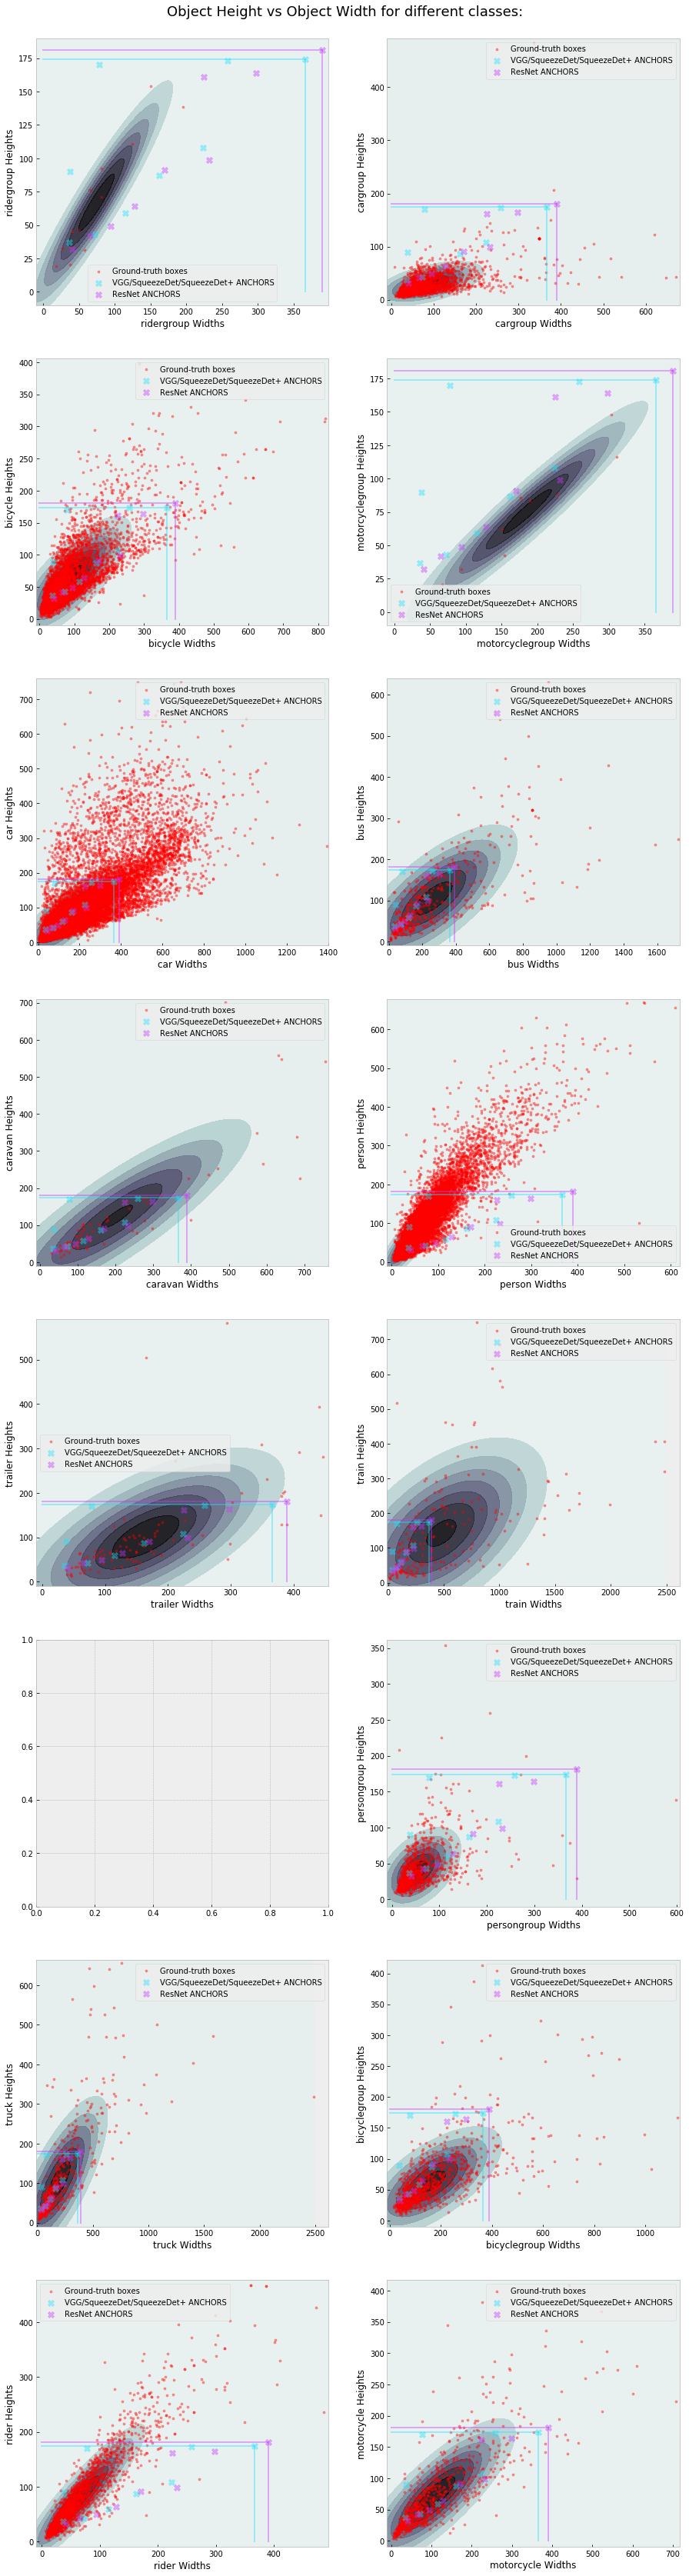

In [8]:
width_scale = 1242/(imgW/2)
height_scale = 375/(imH/2)
plot_class_profiles(width_scale, height_scale, 0.89)

### BGR mean calculation

In [9]:
bgr_mean, sum_img, mean_img = get_bgr_mean('train')
print("BGR MEAN:", bgr_mean)

Shape of first image: (1024, 2048, 3)
Number of images in dataset: train  is: 2975 (0: 2974 )
(1024, 2048, 3)
BGR MEAN: [72.39239876194159, 82.90891754262586, 73.15835921071155]


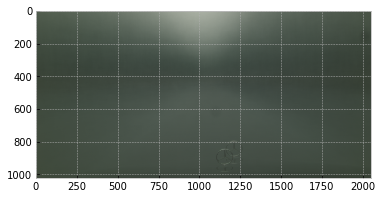

In [10]:
plt.imshow(mean_img.astype(int))
plt.show()